# <font color='green'>VRE Python Library</font> 


## Introduction

This dashboard demonstrates several ways of interacting with the VRE Python Library in a Jupyter notebook 
- Portfolio: Single Swap
- Market: Minimal setup with flat curves
- Analytics: Valuation, cashflows, sensitivities, exposure simulation and XVA

Prerequisites:
- Python 3
- VRE Python module: run "**pip install vannarho-risk-engine**" to get the latest version



## A. VRE Description

### 1. General Introduction to VRE

So, you already had an introduction about what is Open-Source Risk Engine (VRE), why it was created and how it is used. I will quickly introduce you to how it works. Because in order to undertand how to use the python library, it's very important you understand the configuration files.

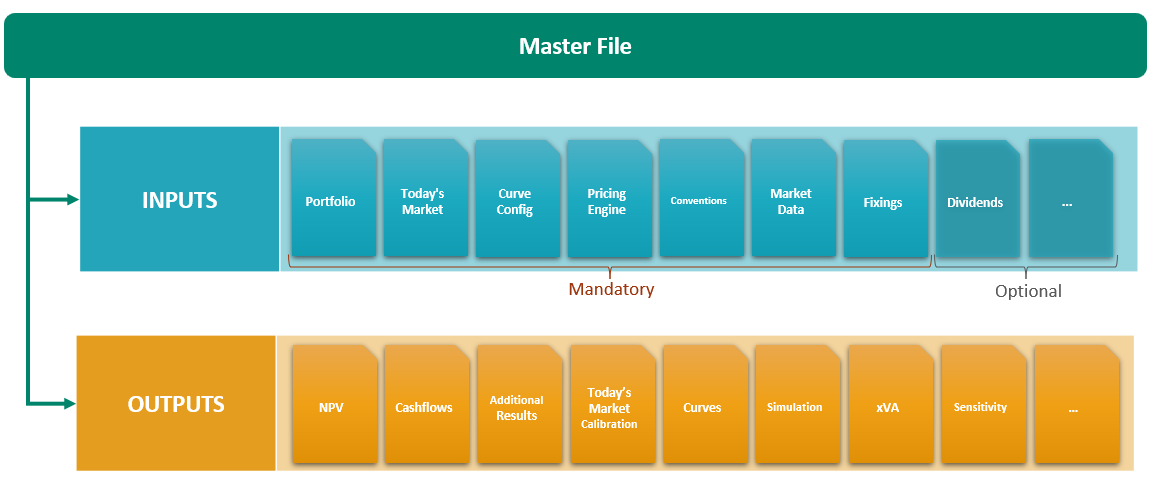

 ### 2. SWIG

We using what our base library - which is Quantlib - is using to wrap their C++ classes/functions into Python. It's called SWIG, which is a quite common wrapper, relatively easy to implement. Relatively.
And it is worth pointing a few things about this:
- Having the implementation of the python functions in C++ is a considerable advantage compared to fully developed Python libraries. We dont have to reinvent the wheel, we just have to build it 
- One of the big advantage of SWIG, in order to wrap functionnalities in Python for example, you have to first build an interface, which is langage-independant. And it's great because all the functionalities that we have already exported in Python, it will require minimal efforts if you want export those into another language like Java or C#
- We are listening to the community about the functionnalities that takes priority 

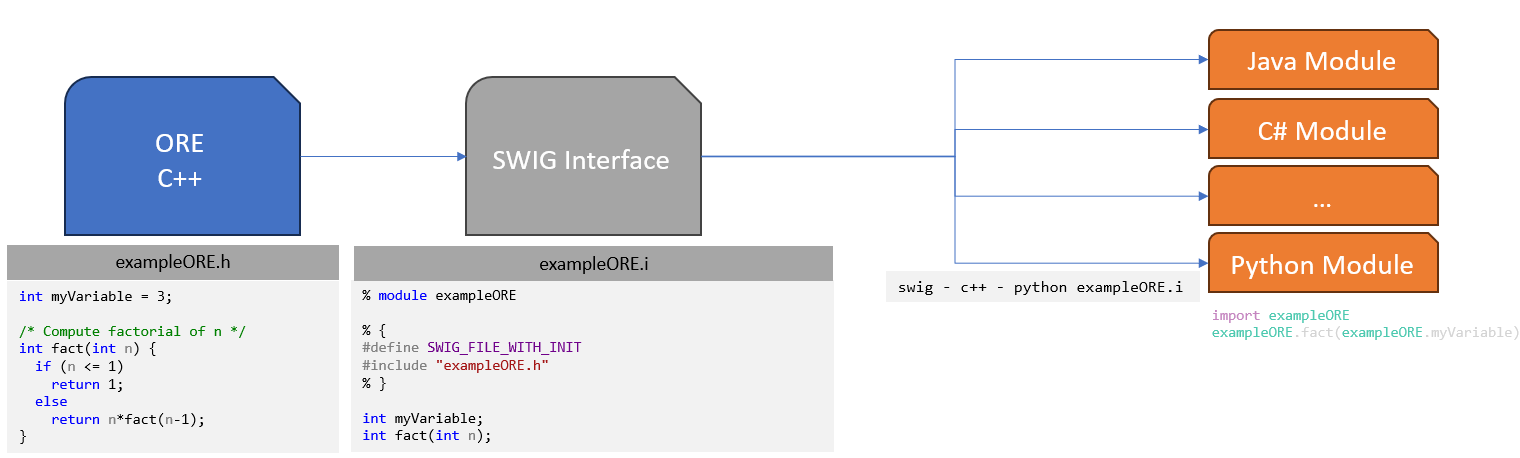

## B. Basic Analytics Example - NPV

### 1. Libraries Loading

In [1]:
# Loading VRE Python library
from VRE import *

# Loading other supporting libraries/tools
import sys, time, math
sys.path.append('..')
import utilities

#pip install pandas matplotlib numpy scipy ipywidgets

#Loading some additional libraries for the creation of graphs and notebook interaction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
from ipywidgets import interact

# Either do a pip install in your virtual environment or here as below
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install ipywidgets


### 2. Running VRE

Kick off a process in VRE, loading all inputs from Input/vre.xml (i.e. the master file) and the files referenced therein. 

This is equivalent to using the VRE command line application "vre.exe vre.xml"

In [2]:
# Loading the Master configuration file and the other configuration file referenced by it
params = Parameters()
params.fromFile("Input/vre.xml")
vre = VREApp(params)

# Running VRE
vre.run()

# Checking Errors
utilities.checkErrorsAndRunTime(vre)

Run time: 0.01 sec
Errors: 0


### 3. Inspecting Inputs

**This would have loaded the main input files:**
1. Portfolio
2. Pricing engine configuration
3. Today's market configuration
4. Conventions
5. Curve configuration
6. Market Data
7. Fixings

In [3]:
# Inspecting the inputs data
inputs = vre.getInputs()

#### 3.a. Inputs - Valuation Date

In [4]:
# Getting the valuation date
currentAsOfDate = inputs.asof()
print(currentAsOfDate)

# Setting a new valuation date
inputs.setAsOfDate("2023-11-02")
print(inputs.asof())

# Setting it bak to initial valuation date
inputs.setAsOfDate("2016-02-05")
print(inputs.asof())

2016-02-05
2023-11-02
2016-02-05


#### 3.b. Inputs - Portfolio

We have 20Y EUR Pay Float - Receive Fixed Swap:
- EUR 10,000,000
- Start Date: 9-Feb-2016
- End Date: 9-Feb-2036
- Float Leg: EUR-EURIBOR-6M Semi-Annually
- Fixed Leg: 2.1% Yearly

In [5]:
# Getting the portfolio data
portfolio = inputs.portfolio()

# Printing composition of the portfolio
print("Trades:", portfolio.size())
for id in portfolio.ids():
    trade = portfolio.get(id)
    print("Trade:  id=%s type=%s" % (id, trade.tradeType()))

# Printing the actual trade(s) contained in this portfolio
portfolioXML = portfolio.toXMLString()
print("\n", portfolioXML)

Trades: 1
Trade:  id=Swap type=Swap

 <Portfolio>
	<Trade id="Swap">
		<TradeType>Swap</TradeType>
		<Envelope>
			<CounterParty>CPTY_A</CounterParty>
			<NettingSetId>CPTY_A</NettingSetId>
			<PortfolioIds/>
			<AdditionalFields/>
		</Envelope>
		<SwapData>
			<LegData>
				<LegType>Fixed</LegType>
				<Payer>false</Payer>
				<Currency>EUR</Currency>
				<PaymentConvention>MF</PaymentConvention>
				<DayCounter>A360</DayCounter>
				<Notionals>
					<Notional>10000000</Notional>
					<Exchanges>
						<NotionalInitialExchange>false</NotionalInitialExchange>
						<NotionalFinalExchange>false</NotionalFinalExchange>
						<NotionalAmortizingExchange>false</NotionalAmortizingExchange>
					</Exchanges>
				</Notionals>
				<ScheduleData>
					<Rules>
						<StartDate>20160209</StartDate>
						<EndDate>20360209</EndDate>
						<Tenor>1Y</Tenor>
						<Calendar>TARGET</Calendar>
						<Convention>MF</Convention>
						<TermConvention>MF</TermConvention>
						<Rule>Forward</Rule>
						

### 4. Analytics & Reports

In the graph below, we show that:
- The mandatory 7 inputs files we just talked about are not analytics dependant 
- There are 4 reports generated (+ the log file) no matter what the analytics are
- While no additional inputs is required for the 3 "vanilla" analytics (i.e. NPV, Cashdflow and Curves), each of these analytics produces its own new report

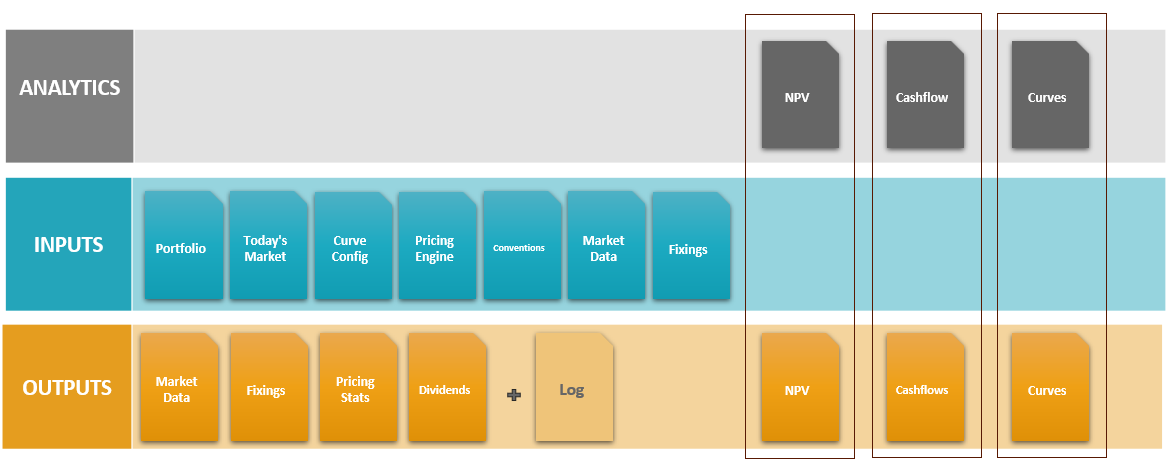

The results of the VRE run above have been written to the Output folder.
Moreover all results are stored in memory and can be queried as follows.

#### 4.1 Analytics List

In [6]:
print("List of currently supported analytics:")
utilities.writeList(vre.getSupportedAnalyticTypes())

print("\n List of analytics queried:")
utilities.writeList(vre.getAnalyticTypes())

List of currently supported analytics:

- CASHFLOW
- CASHFLOWNPV
- NPV
- SENSITIVITY

 List of analytics queried:

- NPV
- CASHFLOW


#### 4.2 Reports List

In [7]:
print("List of reports generated:")
utilities.writeList(vre.getReportNames())

List of reports generated:

- fixings
- curves
- todaysmarketcalibration
- cashflow
- runtimes
- marketdata
- dividends
- pricingstats
- npv


#### 4.3 Inspecting Reports

Pick any of the generated output reports to see its structure (i.e. column name and type) and a preview of its content

In [8]:
nbLinesToDisplay = 10
nbColumnsToDisplay = 10

def analyseAndDisplayReport(reportName): 
    report = vre.getReport(reportName)
    utilities.checkReportStructure(reportName, report)
    display(utilities.format_report(report).iloc[:nbLinesToDisplay, : nbColumnsToDisplay])
interact(analyseAndDisplayReport, reportName=list(vre.getReportNames()))


interactive(children=(Dropdown(description='reportName', options=('fixings', 'curves', 'todaysmarketcalibratio…

<function __main__.analyseAndDisplayReport(reportName)>

#### 4.4 Curve Data Example - Yield Curves

We can interact with the market data and see which curves have been written. Compare to the configuration in Input/todaysmarket.xml. 

Below, we picking the EUR, GBP and USD discount curves, convert dates into times and discounts them into zero rates:

- Step 1 - Recover Discount Factor & Tenor Data

In [9]:
# Get the curves report data
curvesReport = vre.getReport("curves")

# Get the valuation date
asof = vre.getInputs().asof()

# Recover Tenor Dates and Discount Factor Data for EUR, GBP and USD curves
tenorDates = curvesReport.dataAsDate(1)
eurDiscount = curvesReport.dataAsReal(2)
gbpDiscount = curvesReport.dataAsReal(3)
usdDiscount = curvesReport.dataAsReal(4)

- Step 2 - Convert Dates to Time and Calculate Zero Rates

In [10]:
# Initialize 4 Lists of size = number of tenors
nbTenors = curvesReport.rows()
time, eurZero, gbpZero, usdZero = ([None] * nbTenors for i in range(4))

# Set the Year Fraction parameter (VRE Function)
dc = Actual365Fixed()

# Calculate tenor year fraction and the zero rates 
for i in range(0, nbTenors):
    time[i] = dc.yearFraction(asof, tenorDates[i])
    eurZero[i] = -math.log(eurDiscount[i]) / time[i]
    gbpZero[i] = -math.log(gbpDiscount[i]) / time[i]
    usdZero[i] = -math.log(usdDiscount[i]) / time[i]

- Step 3 - Create the Dataframe to print

In [11]:
inputData = list(zip(tenorDates, time, eurDiscount, eurZero, gbpDiscount, gbpZero, usdDiscount, usdZero))
columnNames = ["Tenor Date", "Tenor Time", "EUR DF", "EUR ZR", "GBP DF", "GBP ZR", "USD DF", "USD ZR"]
dataToShow = pd.DataFrame(inputData, columns=columnNames)
print(dataToShow)

     Tenor Date  Tenor Time    EUR DF    EUR ZR    GBP DF  GBP ZR    USD DF  \
0    2016-03-07    0.084932  0.998297  0.020072  0.997879   0.025  0.999616   
1    2016-04-05    0.164384  0.996706  0.020072  0.995899   0.025  0.999216   
2    2016-05-05    0.246575  0.995063  0.020072  0.993855   0.025  0.998795   
3    2016-06-06    0.334247  0.993313  0.020072  0.991679   0.025  0.998306   
4    2016-07-05    0.413699  0.991731  0.020072  0.989711   0.025  0.997854   
..          ...         ...       ...       ...       ...     ...       ...   
235  2035-10-05   19.676712  0.673711  0.020072  0.611453   0.025  0.703655   
236  2035-11-05   19.761644  0.672563  0.020072  0.610156   0.025  0.702327   
237  2035-12-05   19.843836  0.671454  0.020072  0.608903   0.025  0.701044   
238  2036-01-07   19.934247  0.670237  0.020072  0.607529   0.025  0.699636   
239  2036-02-05   20.013699  0.669169  0.020072  0.606323   0.025  0.698400   

       USD ZR  
0    0.004521  
1    0.004772  
2  

- Step 4 - Plot the curves

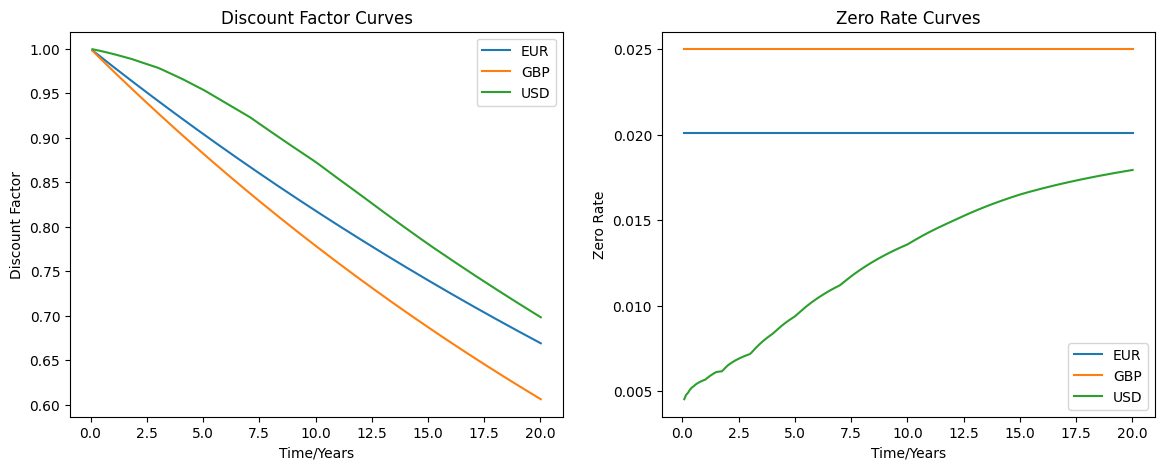

In [12]:
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, eurDiscount, label='EUR')
ax0.plot(time, gbpDiscount, label='GBP')
ax0.plot(time, usdDiscount, label='USD')
ax0.set(xlabel='Time/Years', ylabel='Discount Factor')
ax0.set_title('Discount Factor Curves')
ax0.legend()
ax1.plot(time, eurZero, label='EUR')
ax1.plot(time, gbpZero, label='GBP')
ax1.plot(time, usdZero, label='USD')
ax1.set(xlabel='Time/Years', ylabel='Zero Rate')
ax1.set_title('Zero Rate Curves')
ax1.legend()

plt.show()

## C. Advanced Analytics Example - Sensitivity

### 1. Sensitivity

For the sensitivity analytics, we require 2 new configuration files (plus a different pricing engine file if required) and it will produce 2 new reports:

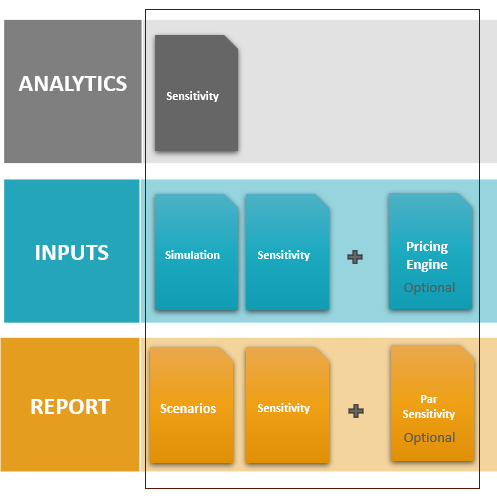

We could now modify the inputs via vre.xml and run again to generate a sensitivity report.

#### 1.1. Setting Sensitivity XML Data
This file specifies how sensitivities are computed for each market component.
Here, we shift only the discount curve and the projection curve, which are identical but used differently.

In [13]:
sensiXML = """
<SensitivityAnalysis>
  <DiscountCurves>
    <DiscountCurve ccy='EUR'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS</Instruments>
        <SingleCurve>true</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </DiscountCurve>
  </DiscountCurves>
  <IndexCurves>
    <IndexCurve index='EUR-EONIA'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS</Instruments>
        <SingleCurve>true</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </IndexCurve>
    <IndexCurve index='EUR-EURIBOR-6M'>
      <ShiftType>Absolute</ShiftType>
      <ShiftSize>0.0001</ShiftSize>
      <ShiftTenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</ShiftTenors>
      <ParConversion>
        <Instruments>DEP,DEP,DEP,DEP,DEP,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS</Instruments>
        <SingleCurve>false</SingleCurve>
        <Conventions>
            <Convention id='DEP'>EUR-EURIBOR-CONVENTIONS</Convention>
            <Convention id='IRS'>EUR-6M-SWAP-CONVENTIONS</Convention>
            <Convention id='OIS'>EUR-OIS-CONVENTIONS</Convention>
        </Conventions>
      </ParConversion>
    </IndexCurve>
  </IndexCurves>
</SensitivityAnalysis>
"""

#### 1.2. Setting Simulation XML Data
For the purpose of sensitivity calculation, the simulation data should just mirror the sensitivity data

In [14]:
simulationXML = """
<Simulation>
  <Market>
    <BaseCurrency>EUR</BaseCurrency>
    <Currencies>
      <Currency>EUR</Currency>
    </Currencies>
    <YieldCurves>
      <Configuration>
        <Tenors>2W,1M,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,25Y,30Y</Tenors>
        <Interpolation>LogLinear</Interpolation>
        <Extrapolation>Y</Extrapolation>
      </Configuration>
    </YieldCurves>
    <Indices>
      <Index>EUR-EONIA</Index>
      <Index>EUR-EURIBOR-6M</Index>
    </Indices>
  </Market>
</Simulation>
"""

#### 1.3. Sensitivity Analytics Addition

In [15]:
# Inserting the 2 new configuration XML files  
inputs.setSensiScenarioData(sensiXML);
inputs.setSensiSimMarketParams(simulationXML)

# Inserting the Sensitivity analytics
inputs.insertAnalytic("SENSITIVITY")


#### 1.4. Re-Running VRE

In [16]:
vre.run()
utilities.checkErrorsAndRunTime(vre)

Run time: 0.02 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


#### 1.5. Inspecting New Reports

In [17]:
nbLinesToDisplay = 20
nbColumnsToDisplay = 10
interact(analyseAndDisplayReport, reportName=list( vre.getReportNames()))

interactive(children=(Dropdown(description='reportName', options=('fixings', 'curves', 'sensitivity_config', '…

<function __main__.analyseAndDisplayReport(reportName)>

**Sensitivity Scenario Report**


For discount/projection IR curve, the shift performed is of the form:

\begin{align}
\mathit{DF'(t) = exp(-(r_t + \alpha ))\times \frac{t-t_0}{365}} 
\end{align}

with 
\begin{align}
\mathit{\alpha} = + 1bps \space in \space the \space UP \space scenario \space\space\space\space\space\space\space\space\\
\mathit{\alpha} = -1bps \space in \space the \space DOWN \space scenario
\end{align}

Then full recalculation of the trade is performed for each scenario and we obtain for each shift scenario a new NPV' at trade level.

**Sensitivity Report**

Using the sensitivity scenario results, We calculate the Delta and the Gamma for each factor:

\begin{align}
\mathit{\delta = NPV^{UP} - NPV^{BASE}}  \space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\\
\mathit{\gamma = NPV^{UP} + NPV^{DOWN} - 2 \times NPV^{BASE}}
\end{align}

### 2. Par-Sensitivity

In VRE, the par-sensitivites are calculated using an inverted Jacobian matrix, the Zero DV01 being the results calculated above

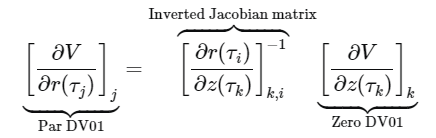

#### 2.1 Par-Sensitivity Configuration

In [18]:
inputs.setParSensi(True)

#### 2.2 Re-Running VRE

In [19]:
vre.run()
utilities.checkErrorsAndRunTime(vre)        

Run time: 0.03 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


#### 2.3 Inspecting New Report

In [ ]:
nbLinesToDisplay = 30
nbColumnsToDisplay = 10
interact(analyseAndDisplayReport, reportName=list( vre.getReportNames()))


interactive(children=(Dropdown(description='reportName', options=('fixings', 'curves', 'sensitivity_config', '…

<function __main__.analyseAndDisplayReport(reportName)>

## D. Advanced Analytics Example - XVA

To run the XVA and the underlying exposure simulation needed to calculate it, we need to 2 new more configuration files and it will generate 7 types of new reports.

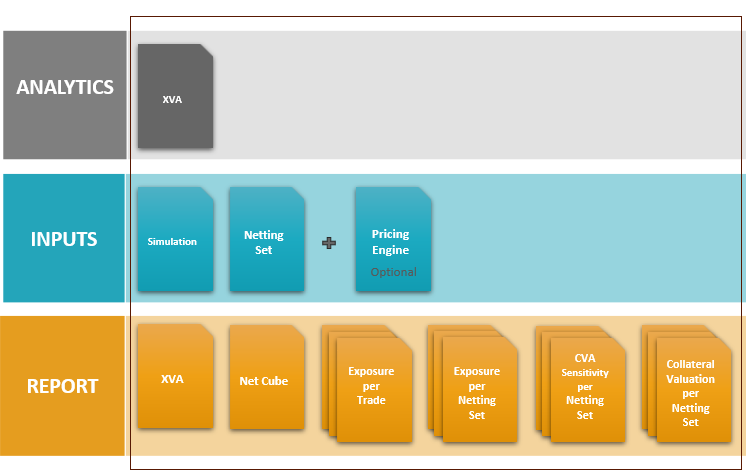

### 1. XML Data Parametrisation

#### 1. Simulation XML File - Part 1 - Market

This section determines the composition of the market used for pricing under future market scenarios:
- The structure/composition of the actively simulated market (IR, FX)
- The method applied to evolve volatility structures even (if not simulated)

In [21]:
mcSimMarketXML ="""
<Simulation>
<Market>
  <BaseCurrency>EUR</BaseCurrency>
    <Currencies>
      <Currency>EUR</Currency>
    </Currencies>
  <YieldCurves>
    <Configuration>
      <Tenors>3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y,30Y</Tenors>
      <Interpolation>LogLinear</Interpolation>
      <Extrapolation>Y</Extrapolation>
    </Configuration>
  </YieldCurves>
  <Indices>
    <Index>EUR-EURIBOR-6M</Index>
    <Index>EUR-EONIA</Index>
  </Indices>
  <SwapIndices>
    <SwapIndex>
      <Name>EUR-CMS-1Y</Name>
      <DiscountingIndex>EUR-EONIA</DiscountingIndex>
    </SwapIndex>
    <SwapIndex>
      <Name>EUR-CMS-30Y</Name>
      <DiscountingIndex>EUR-EONIA</DiscountingIndex>
    </SwapIndex>
  </SwapIndices>
  <DefaultCurves>
    <Names/>
    <Tenors>6M,1Y,2Y</Tenors>
  </DefaultCurves>
  <AggregationScenarioDataCurrencies>
    <Currency>EUR</Currency>
  </AggregationScenarioDataCurrencies>
  <AggregationScenarioDataIndices>
    <Index>EUR-EONIA</Index>
  </AggregationScenarioDataIndices>
</Market>
</Simulation>
"""

#### 1.2. Simulation XML File - Part 2 - Parameters

This section determines the scenario generation given the model defined below.

In [22]:
scenarioGeneratorXML ="""
<Simulation>
  <Parameters>
    <Discretization>Exact</Discretization>
    <Grid>81,3M</Grid>
    <Calendar>EUR</Calendar>
    <Sequence>SobolBrownianBridge</Sequence>
    <Scenario>Simple</Scenario>
    <Seed>42</Seed>
    <Samples>1000</Samples>
  </Parameters>
</Simulation>
"""

#### 1.3. Simulation XML File - Part 3 - CrossAssetModel

This section determines the simulation model composition and the calibration of all components:
- A number n_c of Interest Rate LGM* models (1 for each currency)
- A number (n_c - 1) of FX LGM models (1 for each exchange rate to the base currency)
- A number n_e of Equity LGM models
- A number n_i of Inflation LGM models 
- +The instantaneous correlation structure between each factor (if different than 0)

*Linear Gaussian Markov (LGM) Model

The "Cross Asset Model" (i.e. the Linear Gaussian Markov model) in VRE covers the evolution of the market across six asset/risk classes, it evolves
- Yield curves
- FX rates
- Inflation rates
- Equity prices
- Commodity prices
- Credit spreads
- +The instantaneous correlation structure between each factor (if different than 0)


and there are a few choices of the model components in VRE (LGM-1f vs Hull-White-1f/2f for yield curves, Dodgson-Kainth or Jarrow-Yildirim for Inflation, etc.).

This process takes about a minute. Run-time generally depends on the number of paths we want to generate, portfolio size/complexity and number of time grid points.

In [23]:
crossAssetModelXML = """
<Simulation>
<CrossAssetModel>
  <DomesticCcy>EUR</DomesticCcy>
  <Currencies>
    <Currency>EUR</Currency>
  </Currencies>
  <BootstrapTolerance>0.0001</BootstrapTolerance>
  <InterestRateModels>
    <LGM ccy='default'>
      <CalibrationType>Bootstrap</CalibrationType>
      <Volatility>
        <Calibrate>Y</Calibrate>
        <VolatilityType>Hagan</VolatilityType>
        <ParamType>Piecewise</ParamType>
        <TimeGrid>1.0,2.0,3.0,4.0,5.0,7.0,10.0</TimeGrid>
        <InitialValue>0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01</InitialValue>
      </Volatility>
      <Reversion>
        <Calibrate>N</Calibrate>
        <ReversionType>HullWhite</ReversionType>
        <ParamType>Constant</ParamType>
        <TimeGrid/>
        <InitialValue>0.03</InitialValue>
      </Reversion>
      <CalibrationSwaptions>
        <Expiries> 1Y,  2Y,  4Y,  6Y,  8Y, 10Y, 12Y, 14Y, 16Y, 18Y, 19Y</Expiries>
        <Terms>   19Y, 18Y, 16Y, 14Y, 12Y, 10Y,  8Y,  6Y,  4Y,  2Y,  1Y</Terms>
        <Strikes/>
      </CalibrationSwaptions>
      <ParameterTransformation>
        <ShiftHorizon>0.0</ShiftHorizon>
        <Scaling>1.0</Scaling>
      </ParameterTransformation>
   </LGM>
  </InterestRateModels>
  <ForeignExchangeModels>
    <CrossCcyLGM foreignCcy='default'>
      <DomesticCcy>EUR</DomesticCcy>
      <CalibrationType>Bootstrap</CalibrationType>
      <Sigma>
        <Calibrate>Y</Calibrate>
        <ParamType>Piecewise</ParamType>
        <TimeGrid>1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0</TimeGrid>
        <InitialValue>0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1</InitialValue>
      </Sigma>
      <CalibrationOptions>
        <Expiries>1Y, 2Y, 3Y, 4Y, 5Y, 10Y</Expiries>
        <Strikes/>
      </CalibrationOptions>
    </CrossCcyLGM>
  </ForeignExchangeModels>
  <InstantaneousCorrelations>
    <Correlation factor1='IR:EUR' factor2='IR:GBP'>0.3</Correlation>
    <Correlation factor1='IR:EUR' factor2='FX:GBPEUR'>0</Correlation>
    <Correlation factor1='IR:GBP' factor2='FX:GBPEUR'>0</Correlation>
  </InstantaneousCorrelations>
</CrossAssetModel>
</Simulation>
"""

#### 1.4. Netting Set XML File
- Bilateral EUR CSA
- Threshold = 0
- MTA = 0

In [24]:
nettingSetManagerXML = """
<NettingSetDefinitions>
  <NettingSet>
    <NettingSetId>CPTY_A</NettingSetId>
    <Counterparty>CPTY_A</Counterparty>
    <ActiveCSAFlag>false</ActiveCSAFlag>
    <CSADetails>
      <Bilateral>Bilateral</Bilateral>
      <CSACurrency>EUR</CSACurrency>
      <Index>EUR-EONIA</Index>
      <ThresholdPay>0</ThresholdPay>
      <ThresholdReceive>0</ThresholdReceive>
      <MinimumTransferAmountPay>0</MinimumTransferAmountPay>
      <MinimumTransferAmountReceive>0</MinimumTransferAmountReceive>
      <IndependentAmount>
        <IndependentAmountHeld>0</IndependentAmountHeld>
        <IndependentAmountType>FIXED</IndependentAmountType>
      </IndependentAmount>
      <MarginingFrequency>
        <CallFrequency>1D</CallFrequency>
        <PostFrequency>1D</PostFrequency>
      </MarginingFrequency>
      <MarginPeriodOfRisk>2W</MarginPeriodOfRisk>
      <CollateralCompoundingSpreadReceive>0.00</CollateralCompoundingSpreadReceive>
      <CollateralCompoundingSpreadPay>0.00</CollateralCompoundingSpreadPay>
      <EligibleCollaterals>
        <Currencies>
          <Currency>EUR</Currency>
        </Currencies>
      </EligibleCollaterals>
    </CSADetails>
  </NettingSet>
</NettingSetDefinitions>
"""

#### 1.5. Simulation Pricing Engine XML Data

In [25]:
simulationPricingEngineXML = """
<PricingEngines>
<Product type='Swap'>
  <Model>DiscountedCashflows</Model>
  <ModelParameters/>
  <Engine>DiscountingSwapEngine</Engine>
  <EngineParameters/>
</Product>
</PricingEngines>
"""

#### 1.6. American Monte-Carlo Pricing Engine XML Data
Not used in this case

In [26]:
amcPricingEngineXML = "<PricingEngines></PricingEngines>"

### 2. Other Settings

In [27]:
# Setting the References to the XML Data
inputs.setExposureSimMarketParams(mcSimMarketXML)
inputs.setScenarioGeneratorData(scenarioGeneratorXML)
inputs.setCrossAssetModelData(crossAssetModelXML)
inputs.setNettingSetManager(nettingSetManagerXML)
inputs.setSimulationPricingEngine(simulationPricingEngineXML)
inputs.setAmcPricingEngine(amcPricingEngineXML)

# Setting Exposure/XVA Parameters
inputs.setExposureBaseCurrency("EUR")
inputs.setXvaBaseCurrency("EUR")
inputs.setWriteCube(True)
inputs.setExposureProfiles(True)
inputs.setExposureProfilesByTrade(True)
inputs.setCvaAnalytic(True)
inputs.setAmc(False)
inputs.setNetCubeOutput(True)
inputs.setWriteCube(True)
inputs.setWriteScenarios(True)

# Adding new Analytics
inputs.insertAnalytic("EXPOSURE")
inputs.insertAnalytic("XVA")

### 3. Re-Running VRE

Running the following cells below kicks of a **Monte Carlo simulation**: 
- It evolves today's market into the future along alternative paths
- Ages the portfolio on each path
- Revalues the portfolio through its life and across all paths

In [28]:
vre.run()
utilities.checkErrorsAndRunTime(vre)     

Run time: 3.69 sec
Errors: 1
{ "category": "Warning", "group": "Fixing", "message": "Could not find required fixing ID.", "sub_fields": [ { "name": "exceptionType", "value": "Missing fixing" }, { "name": "fixingDate", "value": "2016-02-05" }, { "name": "fixingId", "value": "EUR-EURIBOR-6M" } ] }


### 4. Inspecting New Reports

We should have several additional reports now:
- exposure_trade_Swap
- exposure-nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- colva_nettingset_CPTY_A
- netcube
- xva

Let us check the simulated data (rates, NPVs) and the resulting exposure report:

In [29]:
nbLinesToDisplay = 10
nbColumnsToDisplay = 10
interact(analyseAndDisplayReport, reportName=list( vre.getReportNames()))

interactive(children=(Dropdown(description='reportName', options=('scenario', 'todaysmarketcalibration', 'runt…

<function __main__.analyseAndDisplayReport(reportName)>

### 5. CVA/DVA Calculations


\begin{align}
\mathit{CVA} &= \sum_{i} \mathit{PD}_{theirs}(t_{i-1},t_i)\times\mathit{LGD}_{theirs}\times \mathit{EPE}(t_i) \\
\mathit{DVA} &= \sum_{i} \mathit{PD}_{ours}(t_{i-1},t_i)\times\mathit{LGD}_{ours}\times \mathit{ENE}(t_i) \\
\end{align}

with

Probability of Default:

\begin{align}
\mathit{PD}(t_i,t_{i+1}) = 1 - e^{\lambda(t_i)\times (t_{i+1}-t_i)} \\
\end{align}

Hazard Rate:
\begin{align}
\mathit{\lambda(t) = \frac{-S(t)}{1-RR}} \\
\end{align}

Loss Given Default:
\begin{align}
LGD = 1-RR \\
\end{align}

In [30]:
# Recovery Rates
xvaAnalytic = vre.getAnalytic("XVA")
xvaMarket = xvaAnalytic.getMarket()
rrOwn = xvaMarket.recoveryRate("BANK")
rrTheir = xvaMarket.recoveryRate("CPTY_A")
print("Own Recovery Rate = " , rrOwn.value())
print("Countparty Recovery Rate = " , rrTheir.value())

# Default Probability Curves
# Note that the current python wheel doesnt
# allow the access to this data point yet
dcOwn = xvaMarket.defaultCurve("BANK")
dcTheir = xvaMarket.defaultCurve("CPTY_A")

Own Recovery Rate =  0.4
Countparty Recovery Rate =  0.4


### 6. Scenario Data Visualisation

#### 6.1 EUR-EONIA Simulated Paths

We take the EUR-EONIA (single) rate as an example of simulated path to show from to tO to the maturity of the trade


EUR-EONIA Rate Value at t=0: 0.01979885172310958
dates:   82
samples: 1000
keys:    2


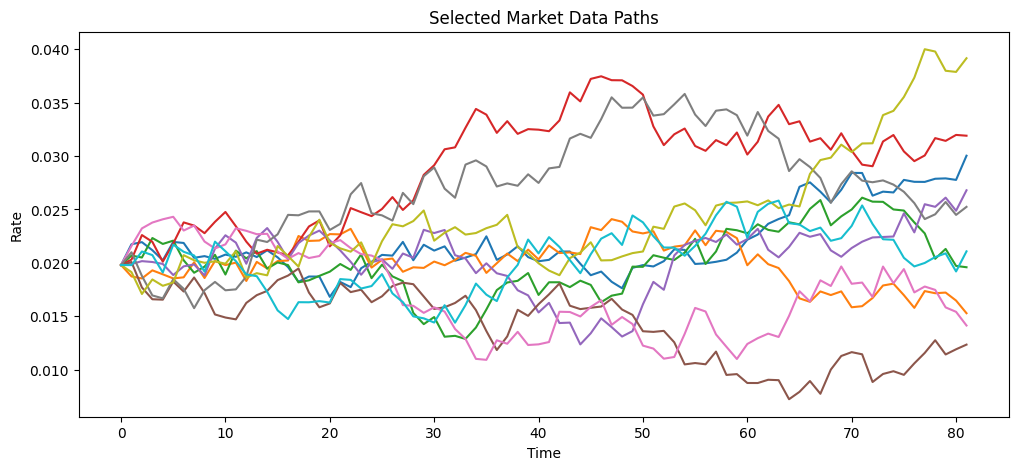

In [31]:
# We store a single index (EONIA) in this case, hence key=0, compare to the file header
keyNumber = 0 

# The number of paths we want to see
numberOfPaths = 10

# Pick the t0 index fixing and pass it to the plot function below as starting point
xvaAnalytic = vre.getAnalytic("XVA")
xvaMarket = xvaAnalytic.getMarket()
eoniaIndex = xvaMarket.iborIndex("EUR-EONIA")
initialRate = eoniaIndex.fixing(inputs.asof())
print("EUR-EONIA Rate Value at t=0:", initialRate)

# We have outsourced the data loading and plotting to utilities
utilities.plotScenarioDataPaths("Output/scenariodata.csv.gz", keyNumber, numberOfPaths, initialRate)


#### 6.2 NPV Simulated Paths

Plotting the NPV paths is easier, since the cube report contains t0

The simulation process produces an NPV "cube": valuations for each trade, through time and across all simulation paths: 1 Trade * 81 Grid Dates* 1000 Simulated Paths in this case

dates: 82
samples: 1001
depths: 1


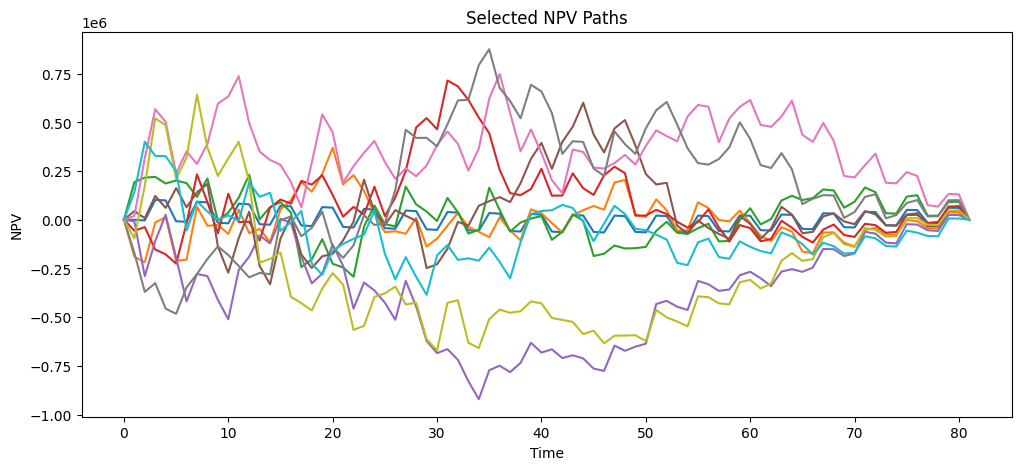

In [32]:
# Get the NPV Cube REport
cubeReport = vre.getReport("netcube")

# Plot 
numberOfPaths = 10
utilities.plotNpvPaths(cubeReport, numberOfPaths)

#### 6.3 Scenario Simulation Distribution

"Exposure" is then computed by post-processing this information, aggregating across all trades in the netting set, and averaging over discounted positive resp. negative NPVs across the simulation paths:   

\begin{align}
\mathit{EPE}(t) &= \mathbb{E}^N\left[ \frac{[\mathit{NPV}(t)]^+}{N(t)} \right] \\
\mathit{ENE}(t) &= \mathbb{E}^N\left[ \frac{[-\mathit{NPV}(t)]^+}{N(t)} \right]
\end{align}

The Expected Positive Exposure (EPE) is our view of exposure, the Expected Negative Exposure (ENE) is the counterparty's perspective.

Below we can see the distribution of the swap:
- Expected Exposure (EE)
- Expected Positive Exposure (EPE)
- Expected Negative Exposiure (ENE)
- Potential Future Exposure (PFE)

at a given date

EE = 1389.80
EPE = 69141.93
ENE = -67752.13
PFE = 585276.86


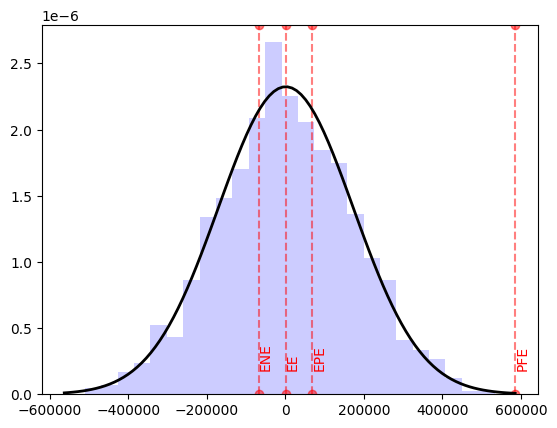

In [33]:
# Recovering the data from the NPV Simulation Cube report
dateIndexColumn = cubeReport.dataAsSize(2)
dateColumn = cubeReport.dataAsString(3)
valueColumn = cubeReport.dataAsReal(6)

# Filter the NPV simulations for a single date chosen
dateChosen = '2016-05-05'
dataToShow = pd.DataFrame(list(zip(dateColumn, valueColumn)), columns=["Date", "NPV"])
valueToShow = dataToShow[dataToShow["Date"] == dateChosen]["NPV"]

# Create the histogram 
plt.hist(valueToShow, bins=25, density=True, alpha=0.2, color='b')

# Fit a normal distribution to the data
mu, std = norm.fit(valueToShow)
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 

# Add EPE to the graph
valueToShowEPE = valueToShow.clip(lower=0)
muEPE, stdEPE = norm.fit(valueToShowEPE) 
plt.axvline(x = muEPE, color = 'red', linestyle = '--', alpha = 0.5, marker = 'o')
plt.text(muEPE,0.2/1000000,'EPE', color = 'red', rotation=90)

# Add ENE to the graph
valueToShowENE = valueToShow.clip(upper=0)
muENE, stdENE = norm.fit(valueToShowENE) 
plt.axvline(x = muENE, color = 'red', linestyle = '--', alpha = 0.5, marker = 'o')
plt.text(muENE,0.2/1000000,'ENE', color = 'red', rotation=90)

# Add PFE to the graph
plt.axvline(x = xmax, color = 'red', linestyle = '--', alpha = 0.5, marker = 'o')
plt.text(xmax,0.2/1000000,'PFE', color = 'red', rotation=90)

# Add the normal distribution to the plot
plt.plot(x, p, 'k', linewidth=2) 
plt.axvline(x = mu, color = 'red', linestyle = '--', alpha = 0.5, marker = 'o')
plt.text(mu,0.2/1000000 ,'EE', color = 'red', rotation=90)

print("EE = {:.2f}".format(mu))
print("EPE = {:.2f}".format(muEPE))
print("ENE = {:.2f}".format(muENE))
print("PFE = {:.2f}".format(xmax))

plt.show() 


#### 6.4 Uncollateralized Exposure

Finally, we can see the EPE, ENE and PFE across the life of the swap 

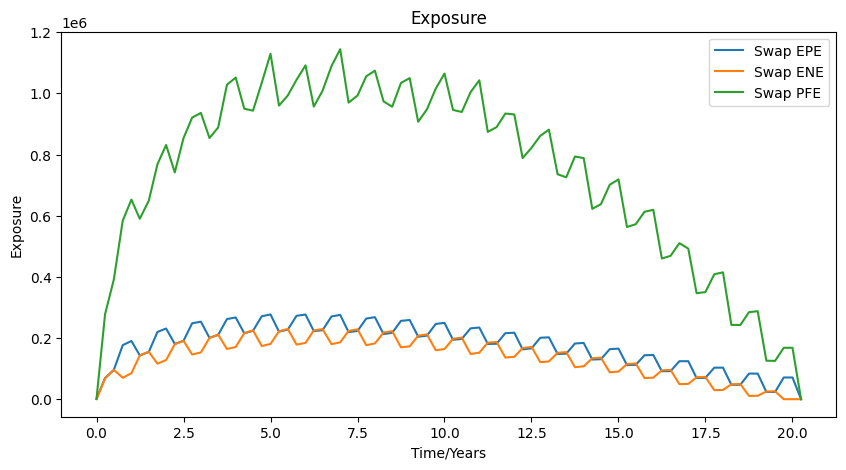

In [34]:
# Get the Trade Exposure report (same as the Nettting Set Exposure report)
report = vre.getReport("exposure_trade_Swap")

# Recovering EPE, ENE & PFE data
time = report.dataAsReal(2)
epe = report.dataAsReal(3);
ene = report.dataAsReal(4);
pfe = report.dataAsReal(7);

# Plotting this data in function of time
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(time, epe, label='Swap EPE')
ax.plot(time, ene, label='Swap ENE')
ax.plot(time, pfe, label='Swap PFE')
ax.set(xlabel='Time/Years')
ax.set(ylabel='Exposure')
ax.set_title('Exposure')
ax.legend()

plt.show()